In [80]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import keras

from sklearn.model_selection import train_test_split
from ipynb.fs.full.a_data_cleaning import readTxt, clean_txt
from time import time
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [2]:
def getProjectDir():
    projectDir = ""
    f = os.getcwd().split('/')
    for d in f:
        if d == 'image-captioning':
            projectDir += d
            break;
        projectDir += d + "/"
    return projectDir

In [3]:
projectDir = getProjectDir()
projectDir

'/home/manojmenpadi/Documents/projects/image-captioning'

In [4]:
img_captions = None
with open(projectDir + "/Data/cleaned_data/img_captions_dictionary.txt", 'r') as f:
    img_captions = f.read()

json_string = img_captions.replace("'","\"")
img_captions = json.loads(json_string)

select_dataset = ""
with open("which_dataset.txt", 'r') as f:
    select_dataset = f.read()

In [6]:
print("Dataset being used : " + select_dataset)

Dataset being used : flickr30k


# Data preprocessing

In [26]:
def clean_data(df):
    dict_data = {}
    for index, row in df.iterrows():
        if index == 0:
            continue
        img_id = row[0].split('.')[0]

        if dict_data.get(img_id) is None:
            dict_data[img_id] = []
        if row[2] != None:
            dict_data[img_id].append(row[2])
        else :
            dict_data[img_id].append(" ")
    
    for key,captions in dict_data.items():
        for i in range(len(captions)):
            if captions[i] != None:
                captions[i] = clean_txt(captions[i])
    
    return dict_data

In [81]:
def splitDict(d):
    n = len(d) * 0.8      
    i = iter(d.items())      
    d1 = dict(itertools.islice(i, n))   # grab first n items
    d2 = dict(i)                        # grab the rest

    return d1, d2

In [92]:
if select_dataset == "flickr8k" :
    train_data = readTxt(projectDir + "/Data/flickr8k/Flickr_TextData/Flickr_8k.trainImages.txt")
    test_data = readTxt(projectDir + "/Data/flickr8k/Flickr_TextData/Flickr_8k.testImages.txt")
    #last row contains null
    train = [row.split(".")[0] for row in train_data.split("\n")[:-1]]
    test = [row.split(".")[0] for row in test_data.split("\n")[:-1]]
else :
    fileName = projectDir + "/Data/flickr30k/descriptions.csv"
    captions = pd.read_csv(fileName, sep='|', header=None, engine='python')
    captions = clean_data(captions)

    keys = list(captions.keys())
    random.shuffle(keys)
    shuffled_captions = {}
    for key in keys:
        shuffled_captions[key] = captions[key]

    train = {}
    test = {}

    for idx, img_id in enumerate(shuffled_captions):
        if idx > len(shuffled_captions)*0.8 :
            test[img_id] = shuffled_captions[img_id]
        else :
            train[img_id] = shuffled_captions[img_id]

In [93]:
print(len(train))
print(len(test))
print(len(captions))

25427
6356
31783


In [94]:
# Addind start and end token to our training data
train_captions = {}

for img_id in train:
    train_captions[img_id] = []
    for cap in img_captions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_captions[img_id].append(cap_to_append)

In [95]:
for key in train_captions.keys():
    print(key)
    print(train_captions[key])
    break

356242936
['startseq a boy in a green and yellow suit kickboxing a punchbag endseq', 'startseq kid in a green and yellow windbreaker practicing karate endseq', 'startseq a boy in green and yellow dress is learning boxing endseq', 'startseq young boy delivers a jumping martial arts kick endseq', 'startseq a boy in green and yellow attire is training endseq']


In [96]:
with open(projectDir + "/Data/cleaned_data/" + "train_captions.txt", "w") as f:
    f.write(str(train_captions))

## Image Preprocessing

In [97]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [98]:
model_new = Model(model.input, model.layers[-2].output)

In [99]:
 def preprocess_img(img):
        img = image.load_img(img, target_size=(224,224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        #  Normalisation
        img = preprocess_input(img)
        return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


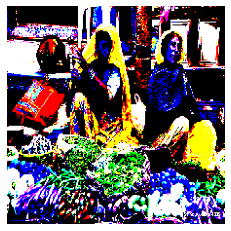

In [100]:
# After processing

# Comment out below 2 lines if using flickr30k
# imageDir = projectDir + "/Data/flickr8k/Images/"
# img = preprocess_img(imageDir + "1000268201_693b08cb0e.jpg")

# Comment out below 2 lines if using flickr8k
imageDir = projectDir + "/Data/flickr30k/flickr30k_imgs/"
img = preprocess_img(imageDir + "5446138396.jpg")
plt.axis("off")
plt.imshow(img[0])
plt.show()

In [101]:
# encoding the processed image 
def encode_image(img):
    img = preprocess_img(img)
    
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [102]:
# encode_image(imageDir + "1000268201_693b08cb0e.jpg")
encode_image(imageDir + "5446138396.jpg")

array([0.38938788, 0.4534046 , 1.0027181 , ..., 0.        , 1.9833114 ,
       0.05162412], dtype=float32)

In [103]:
# we'll store all the encoded images of train dataset in a dictionary where the key would be it's image_id
encoding_train = {}
start = time()

for ix, img_id in enumerate(train):
    img_path = imageDir + img_id + ".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%1000 == 0:
        print("Encoding train data in progress Time step %d" %ix)

end_t = time()
print("Total Time Taken : ", end_t-start)

Encoding train data in progress Time step 0
Encoding train data in progress Time step 1000
Encoding train data in progress Time step 2000
Encoding train data in progress Time step 3000
Encoding train data in progress Time step 4000
Encoding train data in progress Time step 5000
Encoding train data in progress Time step 6000
Encoding train data in progress Time step 7000
Encoding train data in progress Time step 8000
Encoding train data in progress Time step 9000
Encoding train data in progress Time step 10000
Encoding train data in progress Time step 11000
Encoding train data in progress Time step 12000
Encoding train data in progress Time step 13000
Encoding train data in progress Time step 14000
Encoding train data in progress Time step 15000
Encoding train data in progress Time step 16000
Encoding train data in progress Time step 17000
Encoding train data in progress Time step 18000
Encoding train data in progress Time step 19000
Encoding train data in progress Time step 20000
Encod

In [104]:
# Store everything in the disk for later use
with open(projectDir + "/Data/encoded_data/" + "encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train, f)

In [105]:
# we'll store all the encoded images of test dataset in a dictionary where the key would be it's image_id
encoding_test = {}
start = time()

for ix, img_id in enumerate(test):
    img_path = imageDir + img_id + ".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%1000 == 0:
        print("Encoding test data in progress Time step %d" %ix)

end_t = time()
print("Total Time Taken : ", end_t-start)

Encoding test data in progress Time step 0
Encoding test data in progress Time step 1000
Encoding test data in progress Time step 2000
Encoding test data in progress Time step 3000
Encoding test data in progress Time step 4000
Encoding test data in progress Time step 5000
Encoding test data in progress Time step 6000
Total Time Taken :  997.4350619316101


In [106]:
# Store everything in the disk for later use
with open(projectDir + "/Data/encoded_data/" + "encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

 ## Vocabulary Preprocessing

In [107]:
vocab = None
with open(projectDir + "/Data/cleaned_data/" + "vocab_list.txt", 'r') as f:
    vocab = f.read()

json_string = vocab.replace("'","\"")
vocab = json.loads(json_string)

In [108]:
# mapping between index and word is based on 1-based indexing, so that
# we can use 0 for places where there is no word as captions are of different length,
# i.e. 0 will used as the padding word
word2idx = {}
idx2word = {}

for idx, word in enumerate(vocab):
    word2idx[word] = idx+1
    idx2word[idx+1] = word
    
# Also add the start and end token
cnt_words = len(idx2word)
idx2word[cnt_words+1] = 'startseq'
word2idx['startseq'] = cnt_words+1
idx2word[cnt_words+2] = 'endseq'
word2idx['endseq'] = cnt_words+2

vocab_size = len(word2idx)+1

In [109]:
# computing max length of a caption for batch processing
max_len = 0
for key in train_captions.keys():
    for cap in train_captions[key]:
        max_len = max(max_len, len(cap.split()))

print(max_len)

80


In [110]:
with open(projectDir + "/Data/word_indexes/" + "word_to_idx.txt", "w") as f:
    f.write(str(word2idx))
    
with open(projectDir + "/Data/word_indexes/" + "idx_to_word.txt", "w") as f:
    f.write(str(idx2word))